In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc

%matplotlib inline

In [169]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'
# if db does not exist, exit
if not isfile(basedir + dbname + '.sqlite'):
    print('ERROR: ' + dbname + '.sqlite does not exist')
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL

session = create_session(bind = engine, autocommit = False, autoflush = True)


In [3]:
qry0=(session
      .query(StationTBL.StartTimeZone.label('TimeZone'))
      .filter(StationTBL.StartYear>2014)
      .group_by(StationTBL.StartTimeZone))

In [4]:
for row in qry0.all():
    print(row)
    # one value means time zone is the same for all data for 2015 on

('UTC',)


In [5]:
SA=case([(CalcsTBL.Salinity_Bottle_SA!=None, CalcsTBL.Salinity_Bottle_SA)], else_=
         case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_=
         case([(CalcsTBL.Salinity__Unknown_SA!=None, CalcsTBL.Salinity__Unknown_SA)], 
              else_=CalcsTBL.Salinity__Pre1978_SA)
        ))))

In [6]:
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)], 
              else_=ObsTBL.Temperature_Reversing_units)))
TemFlag=ObsTBL.Quality_Flag_Temp

In [7]:
qry1=session.query(ObsTBL.Nitrate_plus_Nitrite_units).group_by(ObsTBL.Nitrate_plus_Nitrite_units)
for row in qry1.all():
    print(row)

(None,)
('umol/L',)


In [8]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                  StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                  StationTBL.Lat,StationTBL.Lon,
                 ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Ammonium,ObsTBL.Ammonium_units,ObsTBL.Chlorophyll_Extracted,
                 ObsTBL.Chlorophyll_Extracted_units,ObsTBL.Nitrate_plus_Nitrite.label('N'),
                  ObsTBL.Silicate.label('Si'),ObsTBL.Silicate_units,SA.label('AbsSal'),Tem.label('T'),TemUnits.label('T_units')).\
            select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
            join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).filter(and_(StationTBL.StartYear>2014,
                                                                StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                                                StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [9]:
df1=pd.DataFrame(qry.all())
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,T,T_units
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.7647,'deg_C_(ITS90)'
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.6880,'deg_C_(ITS90)'
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.6828,'deg_C_(ITS90)'
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.3646,'deg_C_(ITS90)'
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.3586,'deg_C_(ITS90)'


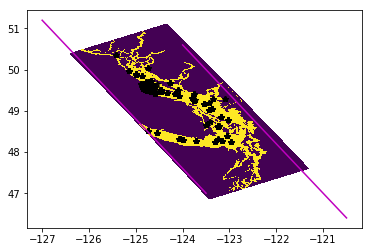

In [10]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as f:
    tmask=np.copy(f.variables['tmask'])
    lon=np.copy(f.variables['nav_lon'])
    lat=np.copy(f.variables['nav_lat'])
plt.pcolormesh(lon,lat,tmask[0,0,:,:])
plt.plot(df1.Lon,df1.Lat,'k*')
x0=-123.5
y0=47
x1=-126
y1=50
x=np.arange(-127,-123,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat>47-3/2.5*(lon+123.5)
plt.plot(x,y,'m-')
x0=-121
y0=47
x1=-123.5
y1=50
x=np.arange(-124,-120,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat<47-3/2.5*(lon+121)
plt.plot(x,y,'m-')

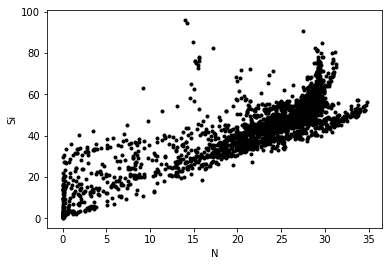

In [11]:
plt.plot(df1['N'],df1['Si'],'k.')
plt.xlabel('N')
plt.ylabel('Si')

In [71]:
from salishsea_tools import gsw_calls, viz_tools, geo_tools, tidetools
import datetime

In [43]:
depths = gsw_calls.generic_gsw_caller('gsw_z_from_p.m', 
                                      [df1.Pressure.values, df1.Lat.values])

In [45]:
depths = depths * -1

In [48]:
df1 = df1.assign(depth = depths)

In [33]:
df1.shape

(2495, 18)

In [35]:
df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon','Pressure']).shape

(2495, 18)

In [50]:
df2 = df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon', 'Si', 'N'])

In [51]:
deptht = (nc.Dataset(
'/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')
          .variables['deptht'][:])

In [ ]:
deptht

In [53]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [131]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_cs_si = np.array([])
list_of_model_ni = np.array([])
list_of_model_si = np.array([])
list_of_depths = np.array([])
for n in df2.index:
    Yind, Xind = geo_tools.find_closest_model_point(df2.Lon[n], df2.Lat[n], 
                                                    X, Y, land_mask = bathy.mask)
    depth = np.argmin(np.abs(deptht - df2.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = datetime.datetime(year = int(df2.Year[n]), month = int(df2.Month[n]),
                                day = int(df2.Day[n]), hour = int(df2.Hour[n]),
                                 minute = int((df2.Hour[n] - int(df2.Hour[n]))*60))
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            ni_val = ((1-delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
            si_val = ((1-delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))

        list_of_lons = np.append(list_of_lons, df2.Lon[n])
        list_of_lats = np.append(list_of_lats, df2.Lat[n])
        list_of_datetimes = np.append(list_of_datetimes, date)
        list_of_cs_ni = np.append(list_of_cs_ni, float(df2['N'][n]))
        list_of_cs_si = np.append(list_of_cs_si, float(df2['Si'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_model_si = np.append(list_of_model_si, si_val)
        list_of_depths = np.append(list_of_depths, depth)

In [86]:
list_of_cs_ni.shape

(2279,)

In [167]:
print('shallow nutrient samples', list_of_cs_ni[list_of_depths < 15].shape)

shallow nutrient samples (644,)


In [168]:
print('deep nutrient samples', list_of_cs_ni[list_of_depths >= 15].shape)

deep nutrient samples (1635,)


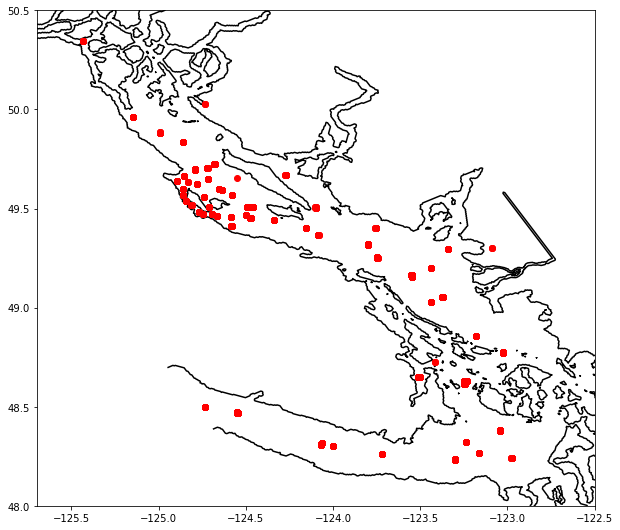

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.7, -122.5);

surface bias =  -3.538846003674042
surface RMSE = 6.917660684363097
surface Willmott = 0.8309561362318326
20m bias =  -1.8867442815140976
20m RMSE = 4.6132739150620194
20m Willmott = 0.7824795348823448
bias =  -2.35359531664837
RMSE = 5.36571883921976
Willmott = 0.912549833123462


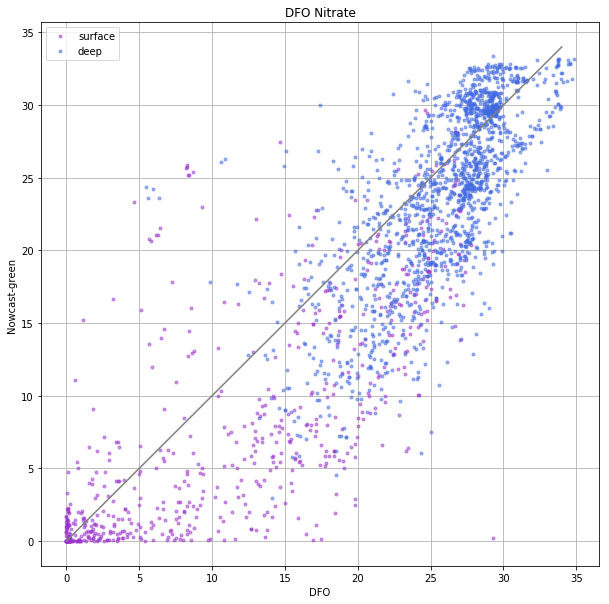

In [140]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_ni[list_of_depths < 15], list_of_model_ni[list_of_depths < 15], 
        '.', color = 'DarkOrchid', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_ni[list_of_depths >= 15], list_of_model_ni[list_of_depths >= 15], 
        '.', color = 'RoyalBlue', alpha = 0.5, label = 'deep')
ax.plot(np.arange(0,35), color = 'grey')
ax.grid('on')
ax.set_title('DFO Nitrate')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths < 15]) 
                               + np.mean(list_of_model_ni[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths < 15] 
                                              - list_of_cs_ni[list_of_depths < 15])**2) /
                              len(list_of_cs_ni[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_ni[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths < 15] 
                                             - list_of_cs_ni[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths < 15] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths >= 15]) 
                               + np.mean(list_of_model_ni[list_of_depths >= 15])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths >= 15] 
                                              - list_of_cs_ni[list_of_depths >= 15])**2) /
                              len(list_of_cs_ni[list_of_depths >= 15]))))
xbar = np.mean(list_of_cs_ni[list_of_depths >= 15])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths >= 15] 
                                             - list_of_cs_ni[list_of_depths >= 15])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths >= 15] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths >= 15] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

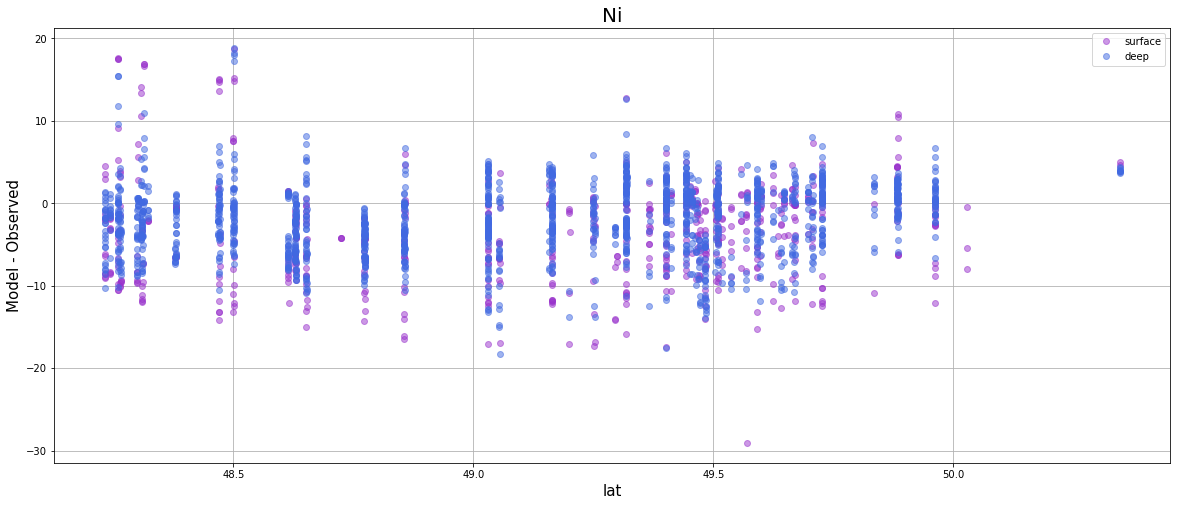

In [137]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths < 15], 
        list_of_model_ni[list_of_depths < 15] 
        - list_of_cs_ni[list_of_depths < 15], 'o', color = 'DarkOrchid',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lats[list_of_depths >= 15], 
        list_of_model_ni[list_of_depths >= 15] 
        - list_of_cs_ni[list_of_depths >= 15], 'o', color = 'RoyalBlue',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

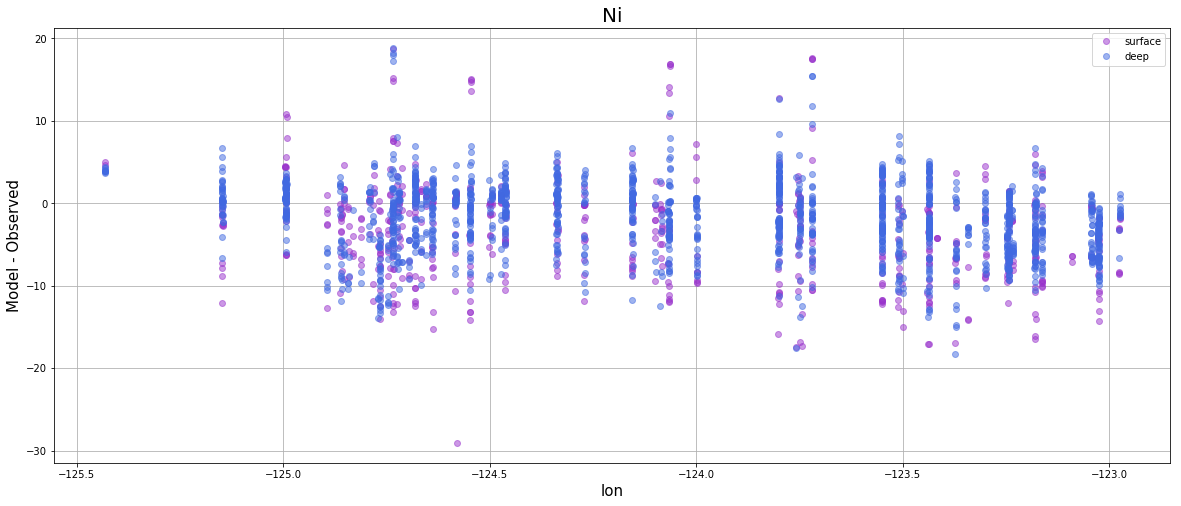

In [138]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths < 15], 
        list_of_model_ni[list_of_depths < 15] 
        - list_of_cs_ni[list_of_depths < 15], 'o', color = 'DarkOrchid',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lons[list_of_depths >= 15], 
        list_of_model_ni[list_of_depths >= 15] 
        - list_of_cs_ni[list_of_depths >= 15], 'o', color = 'RoyalBlue',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

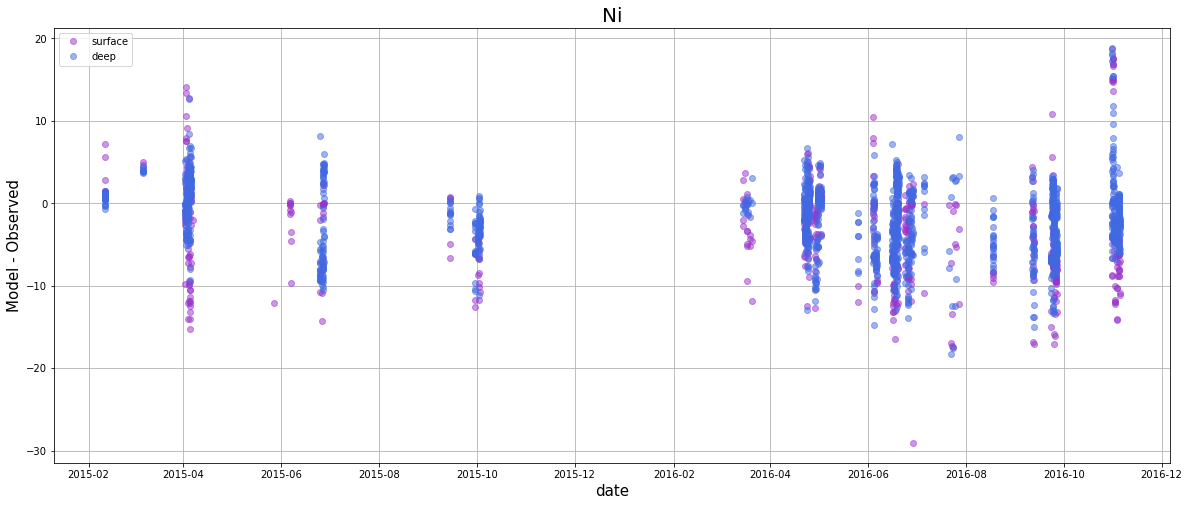

In [139]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths < 15], 
        list_of_model_ni[list_of_depths < 15] 
        - list_of_cs_ni[list_of_depths < 15], 'o', color = 'DarkOrchid',
        alpha =0.5, label = 'surface')
ax.plot(list_of_datetimes[list_of_depths >= 15], 
        list_of_model_ni[list_of_depths >= 15] 
        - list_of_cs_ni[list_of_depths >= 15], 'o', color = 'RoyalBlue',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

surface bias =  -14.989891596808667
surface RMSE = 18.830299908140564
surface Willmott = 0.6581290261877007
20m bias =  -11.541982169709314
20m RMSE = 14.531197316454573
20m Willmott = 0.5849100058294445
bias =  -12.516292687941863
RMSE = 15.864570645189147
Willmott = 0.7493683577201395


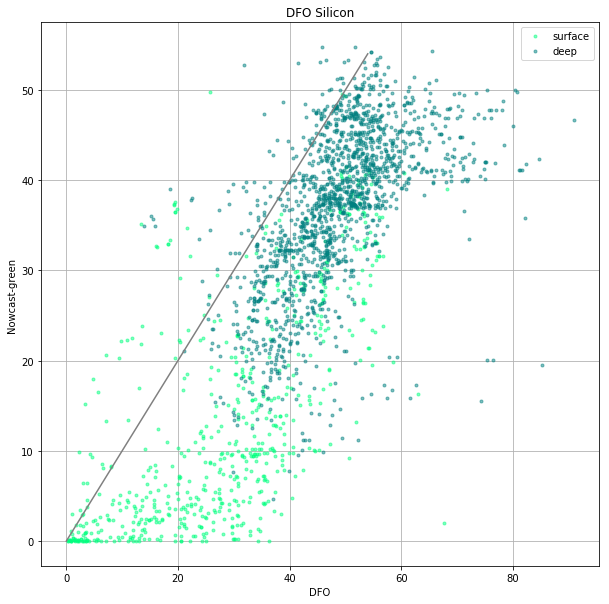

In [144]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_si[list_of_depths < 15], list_of_model_si[list_of_depths < 15], 
        '.', color = 'SpringGreen', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_si[list_of_depths >= 15], list_of_model_si[list_of_depths >= 15], 
        '.', color = 'Teal', alpha = 0.5, label = 'deep')
ax.plot(np.arange(0,55), color = 'grey')
ax.grid('on')
ax.set_title('DFO Silicon')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths < 15]) 
                               + np.mean(list_of_model_si[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths < 15] 
                                              - list_of_cs_si[list_of_depths < 15])**2) /
                              len(list_of_cs_si[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_si[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths < 15] 
                                             - list_of_cs_si[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths < 15] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths >= 15]) 
                               + np.mean(list_of_model_si[list_of_depths >= 15])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths >= 15] 
                                              - list_of_cs_si[list_of_depths >= 15])**2) /
                              len(list_of_cs_si[list_of_depths >= 15]))))
xbar = np.mean(list_of_cs_si[list_of_depths >= 15])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths >= 15] 
                                             - list_of_cs_si[list_of_depths >= 15])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths >= 15] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths >= 15] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

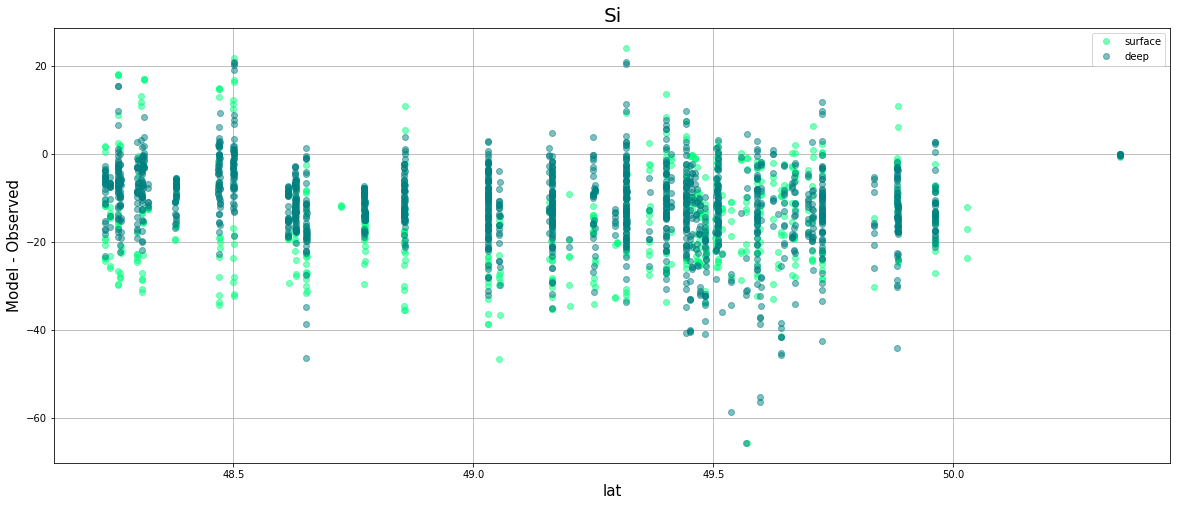

In [145]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths < 15], 
        list_of_model_si[list_of_depths < 15] 
        - list_of_cs_si[list_of_depths < 15], 'o', color = 'SpringGreen',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lats[list_of_depths >= 15], 
        list_of_model_si[list_of_depths >= 15] 
        - list_of_cs_si[list_of_depths >= 15], 'o', color = 'Teal',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

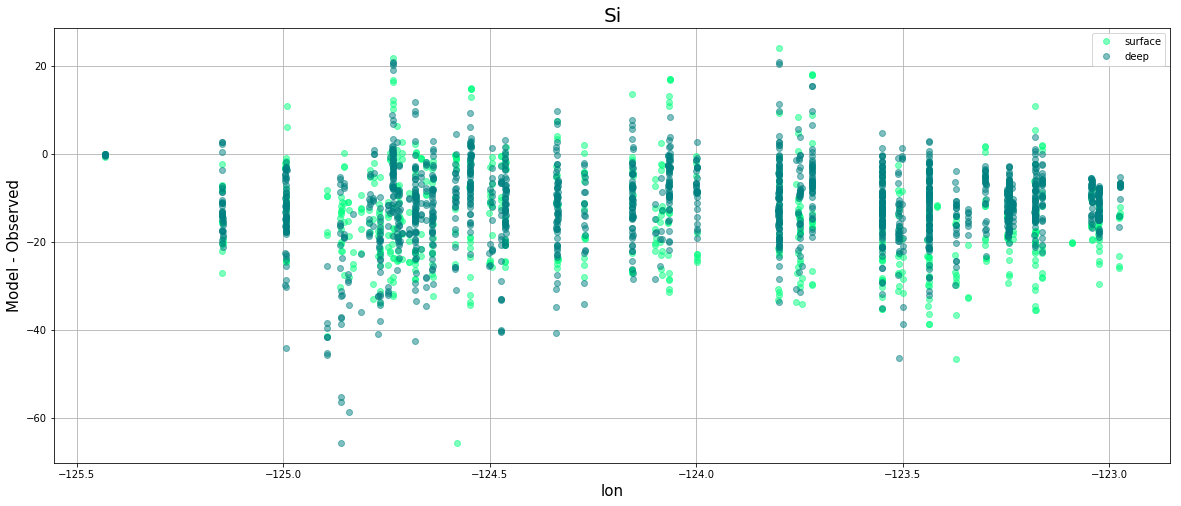

In [146]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths < 15], 
        list_of_model_si[list_of_depths < 15] 
        - list_of_cs_si[list_of_depths < 15], 'o', color = 'SpringGreen',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lons[list_of_depths >= 15], 
        list_of_model_si[list_of_depths >= 15] 
        - list_of_cs_si[list_of_depths >= 15], 'o', color = 'Teal',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

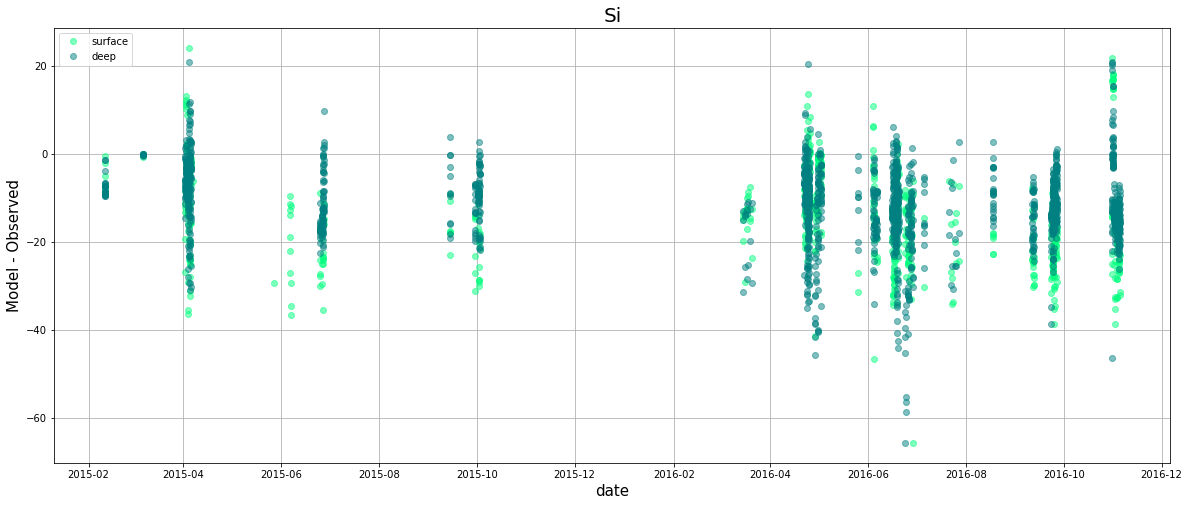

In [147]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths < 15], 
        list_of_model_si[list_of_depths < 15] 
        - list_of_cs_si[list_of_depths < 15], 'o', color = 'SpringGreen',
        alpha =0.5, label = 'surface')
ax.plot(list_of_datetimes[list_of_depths >= 15], 
        list_of_model_si[list_of_depths >= 15] 
        - list_of_cs_si[list_of_depths >= 15], 'o', color = 'Teal',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

In [109]:
df3 = df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon',
                         'depth', 'Chlorophyll_Extracted'])

In [112]:
df3.shape

(539, 19)

In [111]:
list_of_lons2 = np.array([])
list_of_lats2 = np.array([])
list_of_datetimes2 = np.array([])
list_of_cs_chl = np.array([])
list_of_model_chl = np.array([])
list_of_depths2 = np.array([])
for n in df3.index:
    Yind, Xind = geo_tools.find_closest_model_point(df3.Lon[n], df3.Lat[n], 
                                                    X, Y, land_mask = bathy.mask)
    depth = np.argmin(np.abs(deptht - df3.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = datetime.datetime(year = int(df3.Year[n]), month = int(df3.Month[n]),
                                day = int(df3.Day[n]), hour = int(df3.Hour[n]),
                                 minute = int((df3.Hour[n] - int(df3.Hour[n]))*60))
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind]
                                     + nuts.variables['ciliates'][before.hour, depth, Yind, Xind]
                                     +nuts.variables['flagellates'][before.hour, depth, Yind, Xind]) + 
                       (delta)*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind]
                                     + nuts.variables['ciliates'][before.hour, depth, Yind, Xind]
                                     +nuts.variables['flagellates'][before.hour, depth, Yind, Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind]
                                     + nuts.variables['ciliates'][before.hour, depth, Yind, Xind]
                                     +nuts.variables['flagellates'][before.hour, depth, Yind, Xind]) + 
                       (delta)*(nuts.variables['diatoms'][before.hour, depth, Yind, Xind]
                                     + nuts.variables['ciliates'][before.hour, depth, Yind, Xind]
                                     +nuts.variables['flagellates'][before.hour, depth, Yind, Xind]))
        list_of_lons2 = np.append(list_of_lons2, df3.Lon[n])
        list_of_lats2 = np.append(list_of_lats2, df3.Lat[n])
        list_of_datetimes2 = np.append(list_of_datetimes2, date)
        list_of_cs_chl = np.append(list_of_cs_chl, float(df3['Chlorophyll_Extracted'][n]))
        list_of_model_chl = np.append(list_of_model_chl, chl_val)
        list_of_depths2 = np.append(list_of_depths2, depth)

In [117]:
list_of_cs_chl.shape

(537,)

In [164]:
print('shallow chl samples',list_of_cs_chl[list_of_depths2 < 15].shape)

shallow chl samples (368,)


In [165]:
print('deep chl samples',list_of_cs_chl[list_of_depths2 >= 15].shape)

deep chl samples (169,)


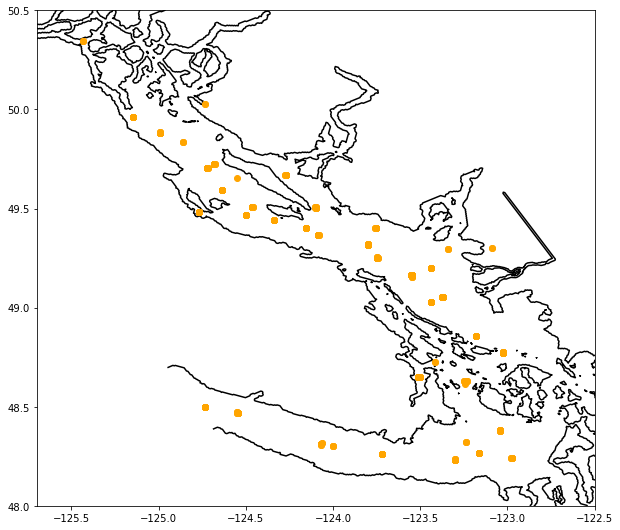

In [119]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons2, list_of_lats2, 'o', color = 'orange')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.7, -122.5);

surface bias =  1.32929405292739
surface RMSE = 3.7156042633343764
surface Willmott = 0.5965416173112374
20m bias =  0.8602995628718089
20m RMSE = 1.5483612785189933
20m Willmott = 0.6250446100472942
bias =  1.181696159408967
RMSE = 3.196153287040885
Willmott = 0.6480941162236973


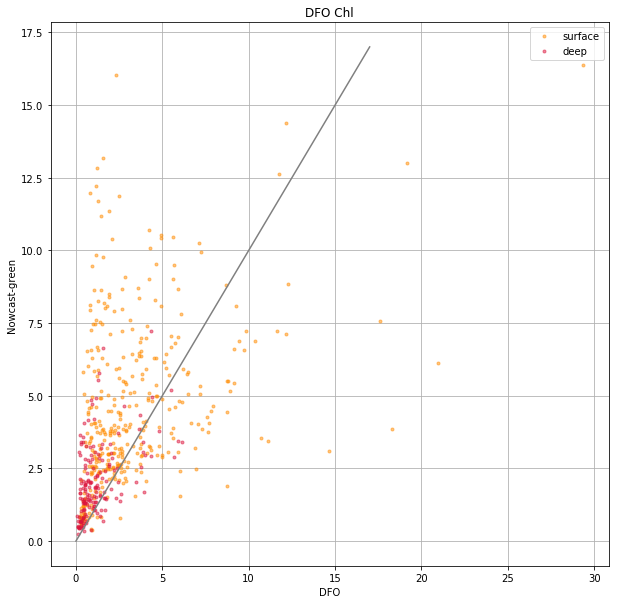

In [157]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_chl[list_of_depths2 < 15], list_of_model_chl[list_of_depths2 < 15], 
        '.', color = 'DarkOrange', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_chl[list_of_depths2 >= 15], list_of_model_chl[list_of_depths2 >= 15], 
        '.', color = 'Crimson', alpha = 0.5, label = 'deep')
ax.plot(np.arange(0,18), color = 'grey')
ax.grid('on')
ax.set_title('DFO Chl')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_chl[list_of_depths2 < 15]) 
                               + np.mean(list_of_model_chl[list_of_depths2 < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl[list_of_depths2 < 15] 
                                              - list_of_cs_chl[list_of_depths2 < 15])**2) /
                              len(list_of_cs_chl[list_of_depths2 < 15]))))
xbar = np.mean(list_of_cs_chl[list_of_depths2 < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_chl[list_of_depths2 < 15] 
                                             - list_of_cs_chl[list_of_depths2 < 15])**2)  / 
                             np.sum((np.abs(list_of_model_chl[list_of_depths2 < 15] - xbar) 
                                     + np.abs(list_of_cs_chl[list_of_depths2 < 15] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_chl[list_of_depths2 >= 15]) 
                               + np.mean(list_of_model_chl[list_of_depths2 >= 15])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl[list_of_depths2 >= 15] 
                                              - list_of_cs_chl[list_of_depths2 >= 15])**2) /
                              len(list_of_cs_chl[list_of_depths2 >= 15]))))
xbar = np.mean(list_of_cs_chl[list_of_depths2 >= 15])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_chl[list_of_depths2 >= 15] 
                                             - list_of_cs_chl[list_of_depths2 >= 15])**2)  / 
                             np.sum((np.abs(list_of_model_chl[list_of_depths2 >= 15] - xbar) 
                                     + np.abs(list_of_cs_chl[list_of_depths2 >= 15] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_cs_chl)**2) /
                              len(list_of_cs_chl))))
xbar = np.mean(list_of_cs_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_cs_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) 
                                     + np.abs(list_of_cs_chl - xbar))**2))))

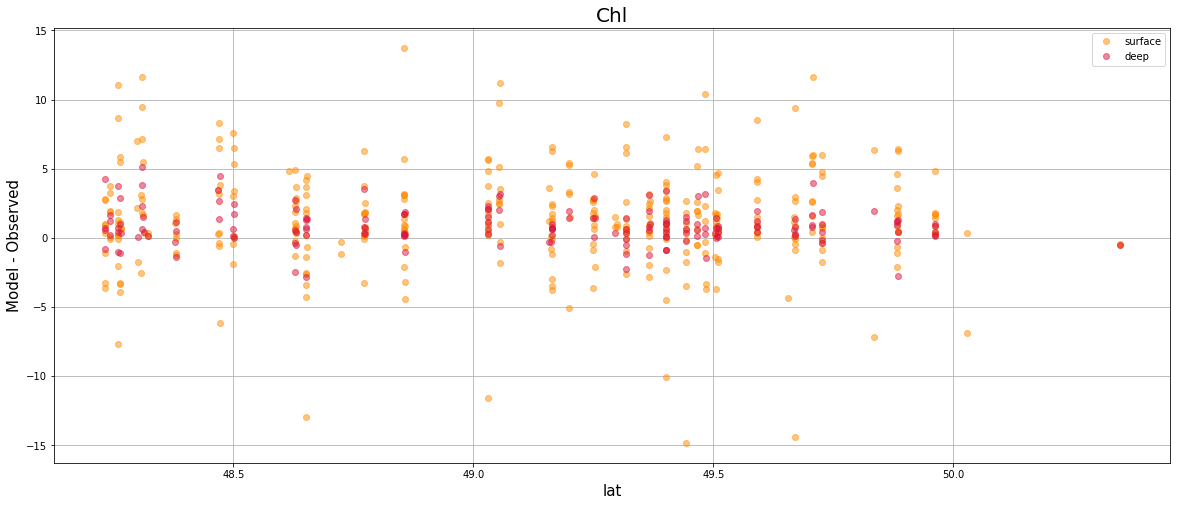

In [159]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats2[list_of_depths2 < 15], 
        list_of_model_chl[list_of_depths2 < 15] 
        - list_of_cs_chl[list_of_depths2 < 15], 'o', color = 'DarkOrange',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lats2[list_of_depths2 >= 15], 
        list_of_model_chl[list_of_depths2 >= 15] 
        - list_of_cs_chl[list_of_depths2 >= 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);

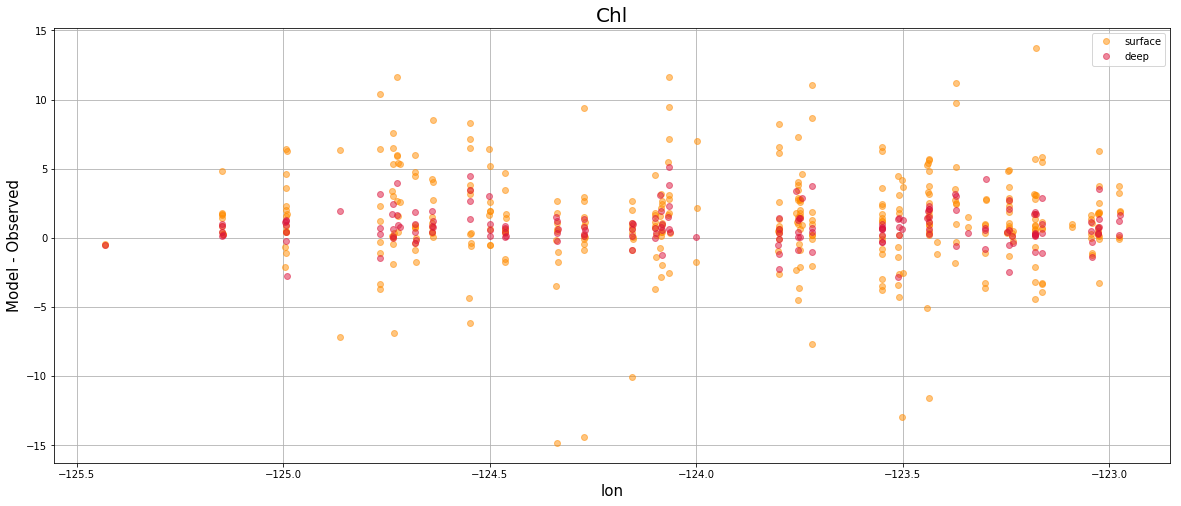

In [160]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons2[list_of_depths2 < 15], 
        list_of_model_chl[list_of_depths2 < 15] 
        - list_of_cs_chl[list_of_depths2 < 15], 'o', color = 'DarkOrange',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lons2[list_of_depths2 >= 15], 
        list_of_model_chl[list_of_depths2 >= 15] 
        - list_of_cs_chl[list_of_depths2 >= 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);

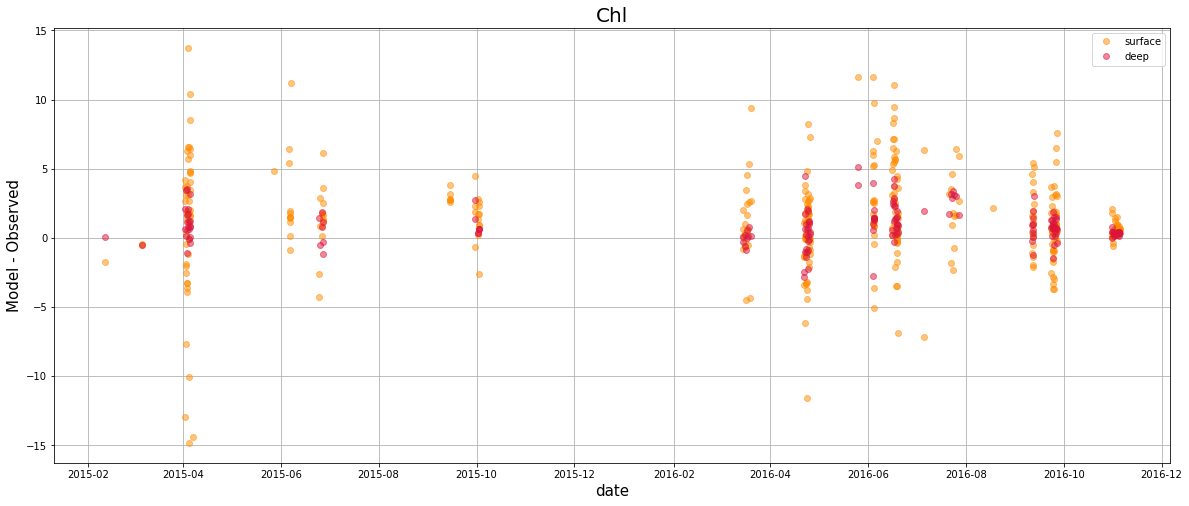

In [161]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes2[list_of_depths2 < 15], 
        list_of_model_chl[list_of_depths2 < 15] 
        - list_of_cs_chl[list_of_depths2 < 15], 'o', color = 'DarkOrange',
        alpha =0.5, label = 'surface')
ax.plot(list_of_datetimes2[list_of_depths2 >= 15], 
        list_of_model_chl[list_of_depths2 >= 15] 
        - list_of_cs_chl[list_of_depths2 >= 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'deep')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Chl', fontsize = 20);